# PA005: High Value Customer Indentification ( Insiders )

In [124]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

import umap.umap_ as umap

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import mixture as mx
from sklearn import manifold as mn 
from sklearn import ensemble as en
from sklearn import decomposition as dd
from sklearn import preprocessing as pp

from plotly import express as px

from matplotlib import pyplot as plt

### 0.2. Load Dataset

In [3]:
# load data
df_raw = pd.read_csv('/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/data/raw/ecommerce.csv', encoding='unicode_escape' )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

## <font color='red'> 1.0. Descrição dos Dados </font>

In [4]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [5]:
cols_new = [ 'invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country' ]
df1.columns = cols_new

### 1.2. Data Dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 8


### 1.3. Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

df1.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

### 1.6. Change Types

In [12]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1. Numerical Attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.2. Categorical Attributes

In [16]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


<b>Invoice No</b>

In [17]:
# problema: Temos o invoice com letras e numeros
#df1['invoice_no'].astype( int )

# Identificação
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool ( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number os invoices: {}'.format( len ( df_letter_invoices ) ) ) 
print( 'Total number os negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0 ] ) ) )

Total number os invoices: 9291
Total number os negative quantity: 9288


In [18]:
#cat_attributes['invoice_no'].astype( int )
len( cat_attributes.loc[ cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), 'invoice_no'].drop_duplicates() )
#cat_attributes.loc[173995, : ]

3839

<b>Stock Code</b>

In [19]:
# stock code
#at_least_one_string = cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool ( re.search( '[^0-9+]', x ) ) ), 'stock_code'].head()

#print( at_least_one_string )

#
#cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique() 
df1.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.00,France,12583
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
386,536403,POST,POSTAGE,1,2016-11-29,15.00,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,Germany,12662
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001


In [20]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool ( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

<b>Description</b>

In [21]:
df1.head()

# Ação: deletar description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


<b>Country</b>

In [22]:
len( df1['country'].unique() )

38

In [23]:
df1['country'].value_counts( normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [24]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False )

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


## <font color='red'> 2.0. Filtragem das Variáveis </font>

In [67]:
df2 = df1.copy()

In [68]:
# ===== Numerical Attributes ======
# unit price > 0.04
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ===== Categorical Attributes ======
# stock code != [ POST, D, M, DOT, CRUK ]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK']) ] 

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] ) ] 

## quantity - Negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

## <font color='red'> 3.0. Feature Engineering </font>

In [85]:
df3 = df2.copy()

### 3.1. Feature Creation

In [86]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code','quantity', 'invoice_date', 'unit_price', 'country' ], axis=1 ).drop_duplicates( ignore_index=True)

#### 3.1.1. Gross Revenue

In [87]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, how='left', on='customer_id' )
df_ref.isna().sum()

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_16849/225208262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2. Recency - Day from last Purchase

In [88]:
# Recency - It depends on product returns
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchase['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.3. Quantity of Purchased 

In [89]:
# Número de Produtos - It depends os product returns
df_frequency = (df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                                  .groupby( 'customer_id' )
                                                                  .count()
                                                                  .reset_index()
                                                                  .rename( columns={'invoice_no':'qtde_invoices'}))

df_ref = pd.merge( df_ref, df_frequency, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

#### 3.1.4. Quantity of Items Purchased 

In [90]:
# Número de Produtos - It depends os product returns
df_frequency = (df2_purchase.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' )
                                                                .sum()
                                                                .reset_index()
                                                                .rename( columns={'quantity':'qtde_items'} ))
df_ref = pd.merge( df_ref, df_frequency, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

#### 3.1.5. Quantity of Products Purchased

In [91]:
# Número de Produtos - It depends os product returns
df_frequency = (df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' )
                                                                .count()
                                                                .reset_index()
                                                                .rename( columns={'stock_code':'qtde_products'} ))
df_ref = pd.merge( df_ref, df_frequency, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

#### 3.1.6. Frequency Purchase

In [92]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                    .groupby( 'customer_id' )
                                                    .agg( max_ = ( 'invoice_date', 'max' ),
                                                          min_ = ( 'invoice_date', 'min' ),
                                                         days_ = ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                          buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[[ 'buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [75]:
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

#### 3.1.7. Number os Returns

In [93]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

#### 3.1.7. Average Ticket Value

In [94]:
# Average Ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue' : 'avg_ticket' } ) 
#df_avg_ticket['avg_ticket'] = np.round( df_avg_ticket['avg_ticket'], 2 )
df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
frequency        91
qtde_returns      0
avg_ticket       91
dtype: int64

#### 3.1.8. Average Recency Days

In [95]:
# Average Recency Days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[ True, True] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() #next invoice date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# Average Recency
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# Merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
frequency             91
qtde_returns           0
avg_ticket            91
avg_recency_days    2816
dtype: int64

## <font color='red'> 4.0. EDA ( Exploratory Data Analysis )</font>

In [109]:
df4 = df_ref.dropna()

### 4.3. Estudo do Espaço

In [110]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].copy()

In [111]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )

### 4.3.3. Tree-Based Embedding

In [112]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

# dataframe Leaf

In [113]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

## <font color='red'> 7.0. Hyperparameter Fine-Tunning </font>

In [117]:
X = df_tree.copy()

In [121]:
X.head()

,embedding_x,embedding_y
0,-1.794532,-5.616612
1,-11.619191,3.220745
2,-1.727290,-6.593994
3,12.381402,8.551535
4,15.797197,0.220842


## <font color='red'> 8.0. Model Training </font>

### 8.1. Final Model

In [122]:
# model definition GMM
k = 13
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state = 42 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

### 8.2. Cluster Validation

In [126]:
## SS ( Silhouette Score )
print ( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.6773965954780579


## <font color='red'> 9.0. Cluster Analysis </font>

In [548]:
df9 = X.copy()
df9['cluster'] = labels

In [547]:
df9 = df4.copy() #dados não escalados para não precisar voltar aos valores reais
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647,4
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667,12
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000,4
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000,10
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333,11


### 9.1. Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

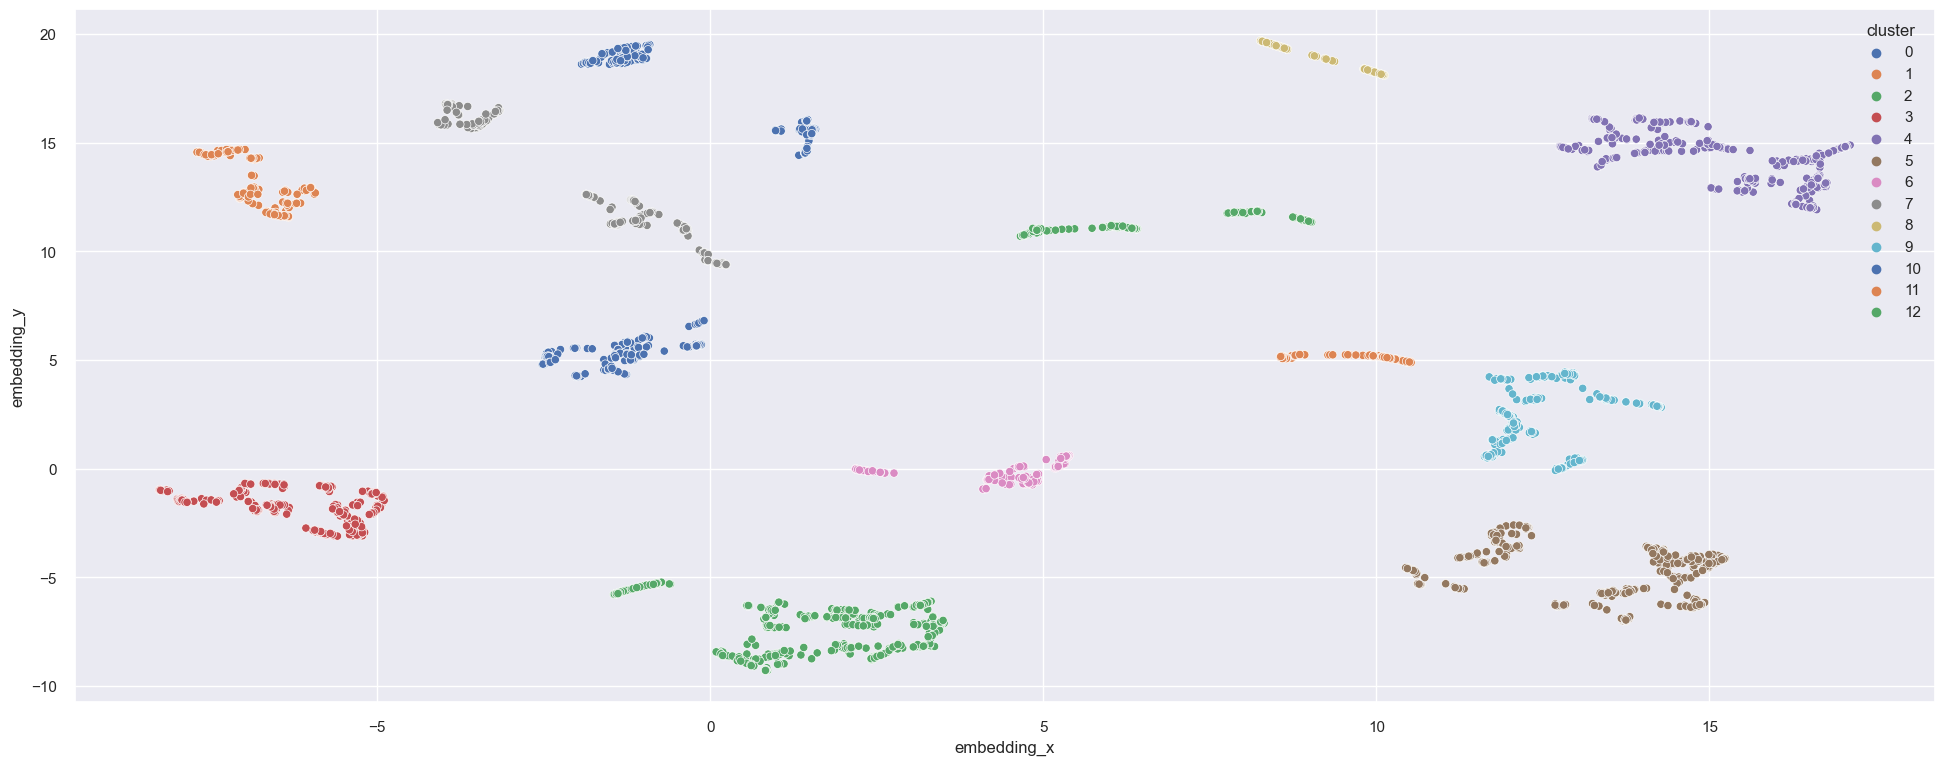

In [549]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [529]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

In [530]:
# visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
# visualizer.fit( X )
# visualizer.finalize()

### 9.2. 2D Plot

In [550]:
df9.head(10)

,embedding_x,embedding_y,cluster
0,14.944745,14.940888,4
1,6.130150,11.124733,12
2,14.408968,15.951004,4
3,-1.842756,5.526695,10
4,-6.375777,12.813644,11
5,11.746593,-3.040096,5
6,15.269126,14.746405,4
7,3.105504,-8.197534,2
8,14.979665,15.731500,4
9,4.775242,-0.400791,6


In [ ]:
df_viz = df9.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )


### 9.3. UMAP

In [345]:
#X.head()

In [346]:
# reducer = umap.UMAP( n_neighbors=50, random_state = 42 )
# embedding = reducer.fit_transform( X ) # espaço projetado

# # embeddind
# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]

# # plot UMAP
# sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ), data=df_viz )


### 9.4. Cluster Profile

In [552]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3232.59,56.0,171.0,0.028302,35.0,12
2,12583,6705.38,2.0,232.0,0.040323,50.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,10
4,15100,876.00,333.0,3.0,0.073171,22.0,11


In [553]:
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3232.59,56.0,171.0,0.028302,35.0,12
2,12583,6705.38,2.0,232.0,0.040323,50.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,10
4,15100,876.00,333.0,3.0,0.073171,22.0,11


In [554]:
# Number of Customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency Days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Average Invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,186,6.266846,497.823871,111.112903,11.548387,0.022069,1.155914
1,1,84,2.830189,2692.810238,76.476190,128.511905,0.073652,32.559524
2,2,415,13.982480,1221.472892,61.371084,53.219277,0.042040,9.122892
3,3,279,9.400270,954.046989,77.362007,36.530466,0.081823,5.709677
4,4,373,12.567385,10502.792386,19.268097,475.528150,0.110615,187.120643
5,5,404,13.611860,1689.073490,54.809406,89.175743,0.049992,11.542079
6,6,134,4.514825,4595.674627,52.194030,101.134328,0.063555,39.432836
7,7,240,8.086253,686.339375,85.112500,18.233333,0.187062,2.533333
8,8,95,3.200809,2291.139684,29.957895,222.115789,0.031576,0.663158
9,9,272,9.164420,2315.843676,33.452206,128.316176,0.032634,15.996324


In [555]:
df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
4,4,373,12.567385,10502.792386,19.268097,475.528150,0.110615,187.120643
6,6,134,4.514825,4595.674627,52.194030,101.134328,0.063555,39.432836
12,12,145,4.885445,3164.115448,34.427586,173.841379,0.060415,23.482759
1,1,84,2.830189,2692.810238,76.476190,128.511905,0.073652,32.559524
9,9,272,9.164420,2315.843676,33.452206,128.316176,0.032634,15.996324
8,8,95,3.200809,2291.139684,29.957895,222.115789,0.031576,0.663158
5,5,404,13.611860,1689.073490,54.809406,89.175743,0.049992,11.542079
2,2,415,13.982480,1221.472892,61.371084,53.219277,0.042040,9.122892
3,3,279,9.400270,954.046989,77.362007,36.530466,0.081823,5.709677
10,10,175,5.896226,827.409714,92.022857,26.811429,0.161952,22.868571


4   Cluster Insiders

6/12Clusters Quase Insiders

1  Cluster Precisa de Mais Valor "Expend Money"

9   Cluster Mais valor / Frequencia





In [556]:
# pickle_out = open( "/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/data/processed/clusters.pickle", "wb" )
# pickle.dump( df_cluster, pickle_out )
# pickle_out.close() 

In [356]:
# pickle_in = open("/Users/thiago/Thiago/Data_Science/comunidade_ds/insiders_clustering/data/processed/clusters.pickle","rb")
# cluster_rec = pickle.load(pickle_in)

### Cluster Insiders: ( Cluster 4 )
    - Número de customers: 373 ( 12,5% dos customers )
    - Faturamento médio: 10500
    - Recência em média: 19 dias
    - Média de produtos comprados: 475 produtos
    - Frequência de produtos comprados: 0,11 produtos/dia

### Cluster 02:
    - Número de customers: 31 ( 71% dos customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52

### Cluster 03:
    - Número de customers: 4335 ( 99% dos customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57

## <font color='red'> 10.0 Análise Exploratória de Dados </font>

In [557]:
df10 = df92.copy()

### 10.1 MindMap de Hipóteses

1. Fenômeno
2. Entidades ( Customer, Location, Financy, Family )
3. Características da Entidade ( Customer=Nome, Idade, Salário, Escolaridade, ... )

### 10.2 Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação


In [361]:
# Afirmação   |   Cluster  |   Tendo Base (Chute)

#### Hipóteses Compra:

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio 10% acima dos clusters 9 e 1.
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos.
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compra acima de 10% do total de compras.**
6. **Os clientes do cluster insiders tem um número de devoluções abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana do faturamenro geral.**
8. **O percentil do gmv pelos clientes insiders.**

##### H4: **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**

**RESPOSTA**: Verdadeira, o cluster insider possue um volume de compra de produtos de 48%.

In [558]:
#df10.loc[ df10['cluster' == 5,['cluster', 'qtde_products']].groupby( 'cluster' ).sum().reset_index()

# soma da quantidade de produtos do cluster Insiders
df_sales_insiders = df10.loc[ df10['cluster'] == 4, 'qtde_products'].sum()

# soma da quantidade de produtos total
df_sales_total = df10.loc[ :, 'qtde_products' ].sum()

# relação entre os totais
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders: 48.69%


#### H5: **Os clientes do cluster insiders possuem um volume (faturamento) de compra acima de 10% do total de compras.**

**RESPOSTA**: Verdadeira, o cluster insider possue um volume de compra de faturamento de 49%.

In [559]:
# soma da quantidade de produtos do cluster Insiders
df_gmv_insiders = df10.loc[ df10['cluster'] == 4, 'gross_revenue'].sum()

# soma da quantidade de produtos total
df_gmv_total = df10.loc[ :, 'gross_revenue' ].sum()

# relação entre os totais
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders / df_gmv_total ) )

% GMV Insiders: 49.01%


#### H6: **Os clientes do cluster insiders tem um número de devolução médio abaixo da média da base total de clientes.**

**Resposta**: Falsa, O cluster insiders tem a média de devolução acima da média geral.

In [560]:
# media de devolucao do cluster insiders
df_avg_returns_insiders = df10.loc[ df10['cluster'] == 4, 'qtde_returns'].mean()

# media de devolucao total
df_avg_returns_all = df10['qtde_returns'].mean()

## 
print( 'Avg Returns Insiders: {} vs Avg Returns All: {}'.format( np.round( df_avg_returns_insiders, 0), np.round( df_avg_returns_all, 0) ) )

Avg Returns Insiders: 187.0 vs Avg Returns All: 35.0


#### H7: **A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana do faturamenro geral.**

**Resposta**: Verdadeira, a mediana do faturamento pelos clientes do cluster é de 342%.

In [508]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 6, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_dif = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total 

print( 'Median Diff: {:.2f}%'.format( 100*gmv_dif) )

Median Diff: 342.39%


#### H8: **O gmv dos clientes insiders estão concentrados no 3 quartil / O percentil do gmv pelos clientes insiders.**

**Resposta**: Falsa, a maior parte do gmv está no primeiro/segundo quartil

In [561]:
np.percentile( df10.loc[df10['cluster'] == 4, 'gross_revenue'], q=0.1) 

1053.33864

In [562]:
np.percentile( df10.loc[df10['cluster'] == 4, 'gross_revenue'], q=0. ) 

1052.55

<AxesSubplot:xlabel='gross_revenue'>

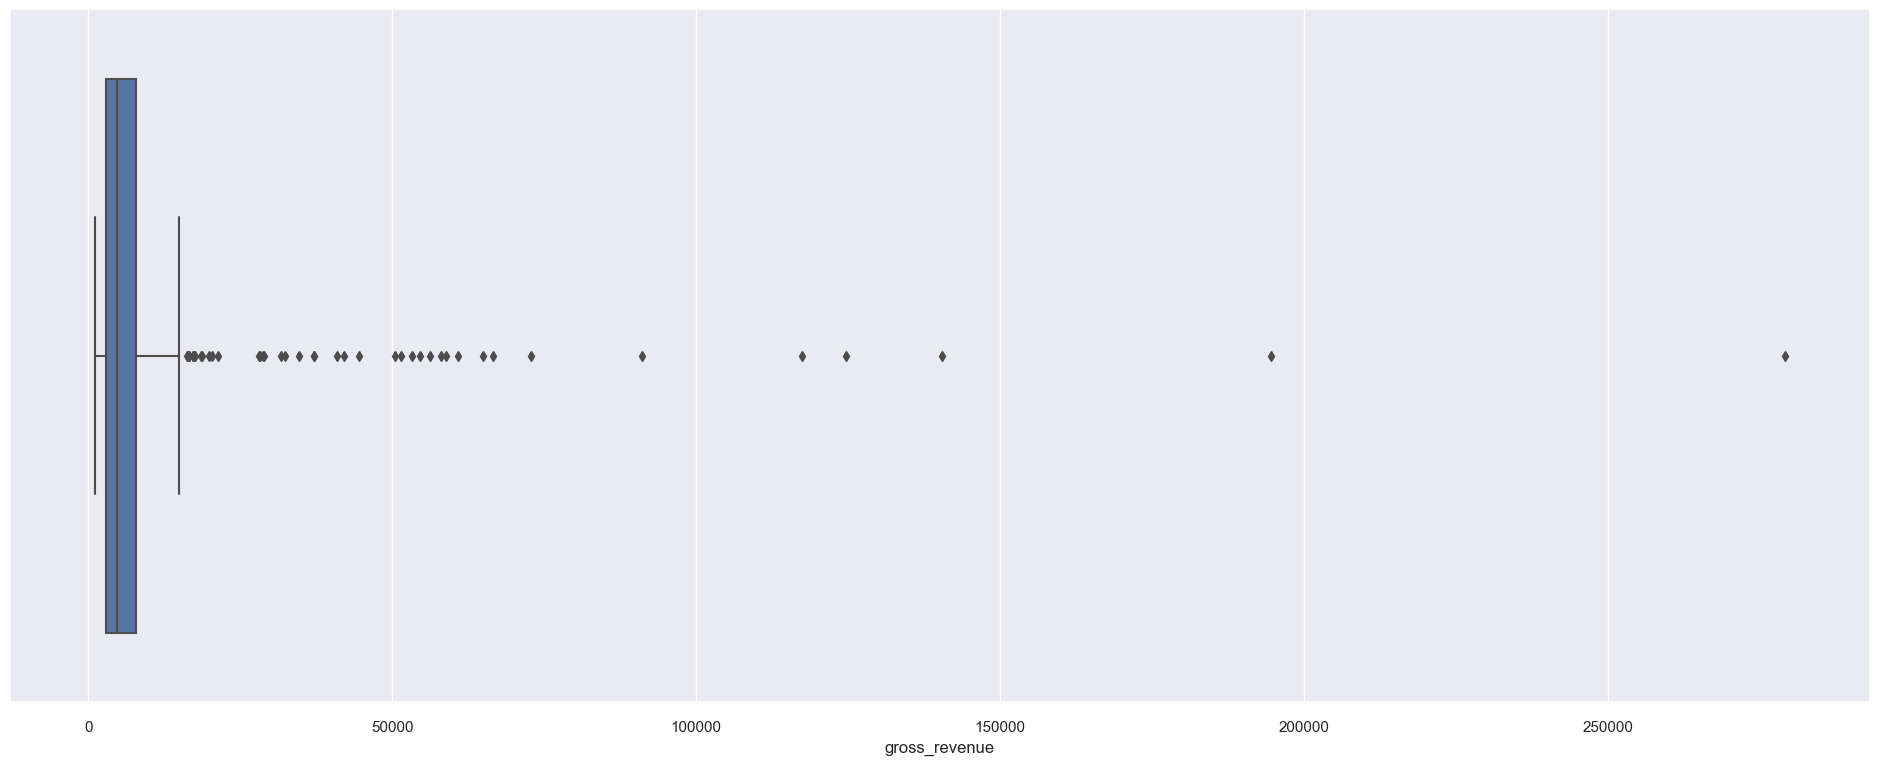

In [563]:
sns.boxplot( x=df10.loc[df10['cluster'] == 4 , 'gross_revenue'] )

<AxesSubplot:xlabel='gross_revenue'>

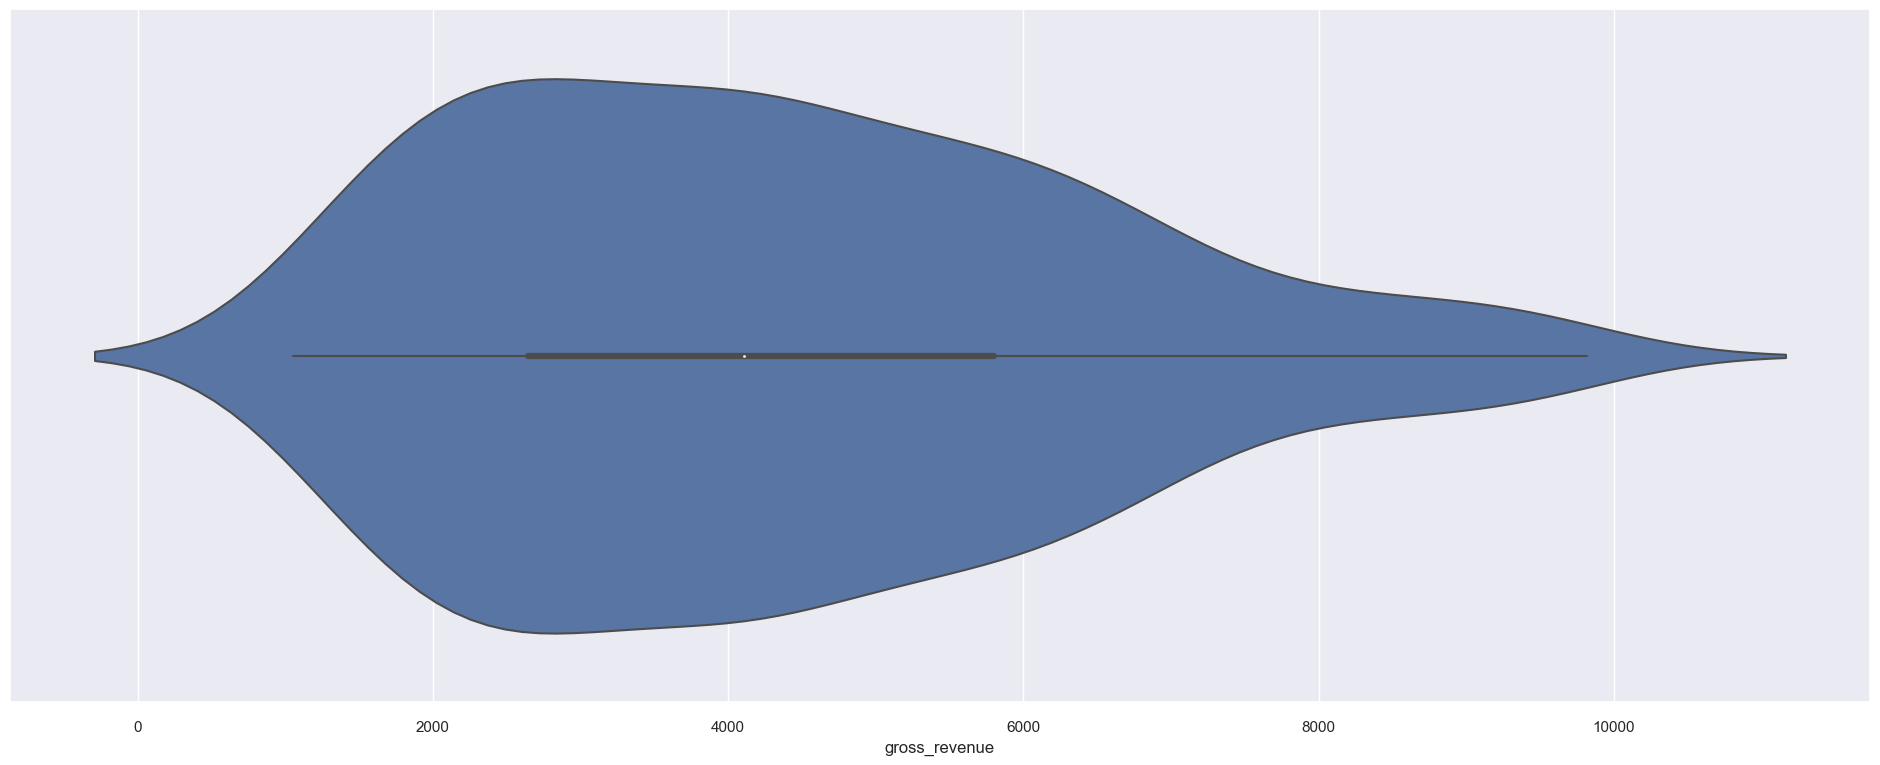

In [564]:
df_aux = df10.loc[ ( df10['cluster'] == 4 ) & ( df10['gross_revenue'] < 10000 ), 'gross_revenue' ]
sns.violinplot( x=df_aux )

#### Hipóteses Cliente:

1. 60% dos clientes do cluster insiders possuem estado civil solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insider estão dentro de um raio de 50 km.
4. 10% das localidades de entrefa do clsuter insider estão dentro do Reino Unido.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem curso superior completo.

#### Hipóteses Produto:

1. 30% dos produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insiders é 10% maior do que a mediana de todos os preços os produtos.
3. O percentil do preço dos produtos comprados pelos clientes do cluster insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

## Perguntas de Negócio

In [406]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,5
1,13047,3232.59,56.0,171.0,0.028302,35.0,1
2,12583,6705.38,2.0,232.0,0.040323,50.0,5
3,13748,948.25,95.0,28.0,0.017921,0.0,7
4,15100,876.00,333.0,3.0,0.073171,22.0,4


### 1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [415]:
df10.loc[ df10['cluster'] == 5, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [416]:
df10.loc[ df10['cluster'] == 5, 'customer_id'].size

373

### 3. Quais as principais características desses clientes ?

#### Cluster Insiders: ( Cluster 4 )
    - Número de customers: 373 ( 12,5% dos customers )
    - Faturamento médio: 10500
    - Recência em média: 19 dias
    - Média de produtos comprados: 475 produtos
    - Frequência de produtos comprados: 0,11 produtos/dia
    - Receita média: 10500,00 dólares


### Determinando o intervalo de confiança dentro do cluster

In [420]:
import scipy.stats as st

In [565]:
df_insiders = df10.loc[ df10['cluster'] == 4, 'gross_revenue' ]

# Via Bootstrap
st.t.interval( alpha=0.95,
               df=len(df_insiders)-1,
               loc=np.mean(df_insiders),
               scale= st.sem( df_insiders ) )

/var/folders/w5/0w2xv4r95g1gfgbzpp2dm6gr0000gn/T/ipykernel_8290/4019683906.py:4: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval( alpha=0.95,


(8136.098121433504, 12869.48665068446)

### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

In [566]:
df_insiders_gmv = df10.loc[df10['cluster'] == 4  , 'gross_revenue' ].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.4900614870966535


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

### 6. Quais as condições para uma pessoa ser elegível ao Insiders ?

### 7. Quais as condições para uma pessoa ser removida do Insiders ?

### 8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

### 10.3 Priorização das Hipóteses

### 10.4 Validação das Hipóteses

## <font color='red'> 11.0 Deploy To Production </font>

In [425]:
# plano
# TMUX



